# Assignment 2 - Time Series Analysis Simulated Series
This notebook contains the code to analyze simulated time series data using various ARIMA models. The goal is to fit different models, compare them using the Bayesian Information Criterion (BIC), and identify the best-fitting model for each series.

## Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox

project_root = os.path.abspath("..")
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

FIG_PATH = os.path.join(project_root, "results", "figures")
os.makedirs(FIG_PATH, exist_ok=True)

from utils import table_kpss, table_adf, arma_model_selection, significant_params, forecast_with_ci, calculate_rmse
from plots import plot_acf_sample, plot_pacf_sample, plot_acf_theoretical, plot_pacf_theoretical, arma_forecast_plot, plot_residuals, plot_acf_pacf_residuals, residuals_normality_test

np.random.seed(4242)

## Construction of the series

$
X_t = 0,6X_{t−1} − 0,3X_{t−2} + ϵ_t + 0,5ϵ_{t−1} + 0,25ϵ_{t−2}$
$

With $n = 240$ and $ϵ_t ∼ N(0,1)$

=== Statistics ===
Mean: -0.0362 (debe ser ≈ 0)
Std. Dsv: 1.5442
Min: -3.55, Max: 4.29


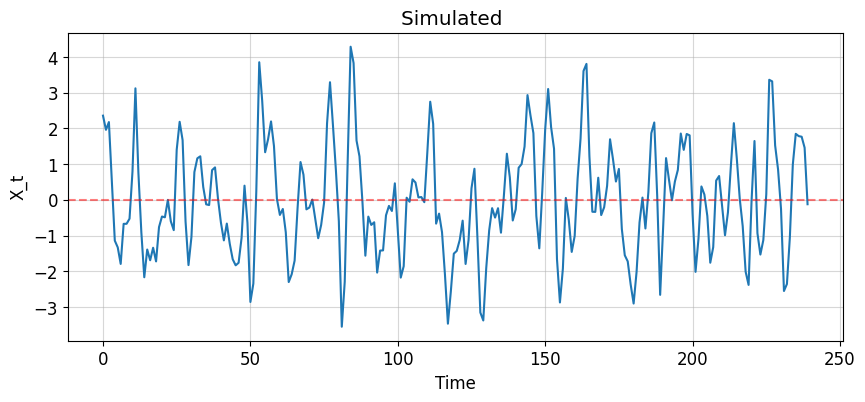

In [2]:
n = 240
phi = [0.6, -0.3]       
theta = [0.5, 0.25]

eps = np.random.normal(0, 1, n)

X = np.zeros(n)

burn = 100 
n_total = n + burn

X_temp = np.zeros(n_total)
eps_temp = np.random.normal(0, 1, n_total)

for t in range(2, n_total):
    X_temp[t] = (phi[0] * X_temp[t-1] + 
                 phi[1] * X_temp[t-2] + 
                 eps_temp[t] + 
                 theta[0] * eps_temp[t-1] + 
                 theta[1] * eps_temp[t-2])

X = X_temp[burn:]
eps = eps_temp[burn:]

print("=== Statistics ===")
print(f"Mean: {X.mean():.4f} (debe ser ≈ 0)")
print(f"Std. Dsv: {X.std():.4f}")
print(f"Min: {X.min():.2f}, Max: {X.max():.2f}")

plt.figure(figsize=(10,4))
plt.plot(X)
plt.title("Simulated ")
plt.xlabel("Time")
plt.ylabel("X_t")
plt.grid(True)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.show()

## Statistical test for stationarity
Two tests where applied to check for stationarity:
- Augmented Dickey-Fuller (ADF) Test
- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test

In [3]:
df_adf  = table_adf(X, autolag="AIC")
df_kpss = table_kpss(X, regression='c', nlags='auto')

print("\n=== Augmented Dickey-Fuller Test (ADF) ===")
display(df_adf)

print("\n=== KPSS Test ===")
display(df_kpss)


=== Augmented Dickey-Fuller Test (ADF) ===


,Statistic,p-value,Lags used,N obs,Crit (1%),Crit (5%),Crit (10%)
0,-7.767924,9.082716e-12,2,237,-3.458247,-2.873814,-2.573311



=== KPSS Test ===


,Statistic,p-value,Lags used,Crit (10%),Crit (5%),Crit (2.5%),Crit (1%)
0,0.078439,0.1,4,0.347,0.463,0.574,0.739


After performing both tests, the results indicated that the series is stationary. The ADF test rejected the null hypothesis of a unit root, while the KPSS test failed to reject the null hypothesis of stationarity. Therefore, we can conclude that the series does not require differencing for further analysis and is stationary.

## ACF And PACF Plots
Fout statistical plots were generated to visualize the autocorrelation and partial autocorrelation of the series, using lag 20.
1. ACF Theoretical Plot
2. PACF Theretical Plot
3. ACF Sample Plot
4. PACF Sample Plot

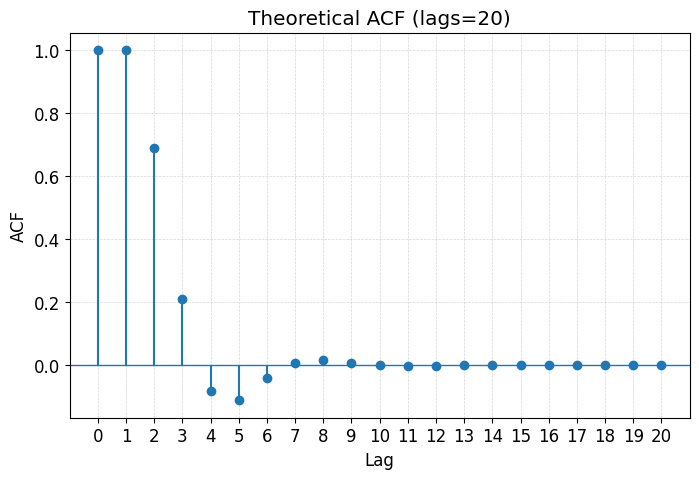

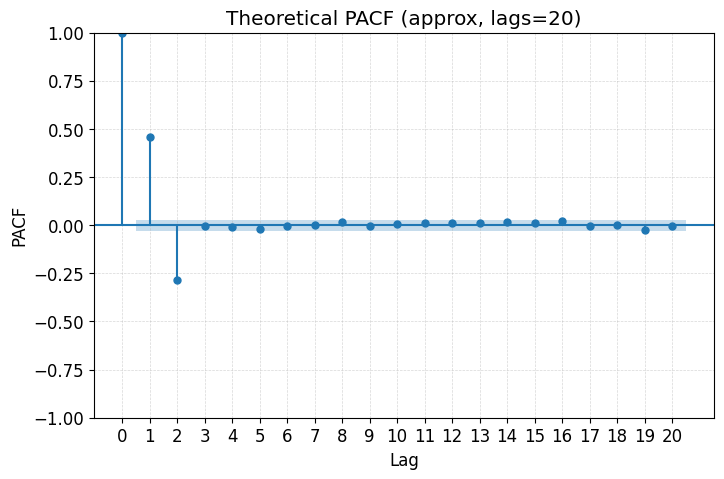

In [4]:
plot_acf_theoretical(phi, theta, lags=20)
plot_pacf_theoretical(phi, lags=20)

The acf decays gradually, while the pacf cuts off after lag 2, suggesting an ARMA(2, 2)  model.

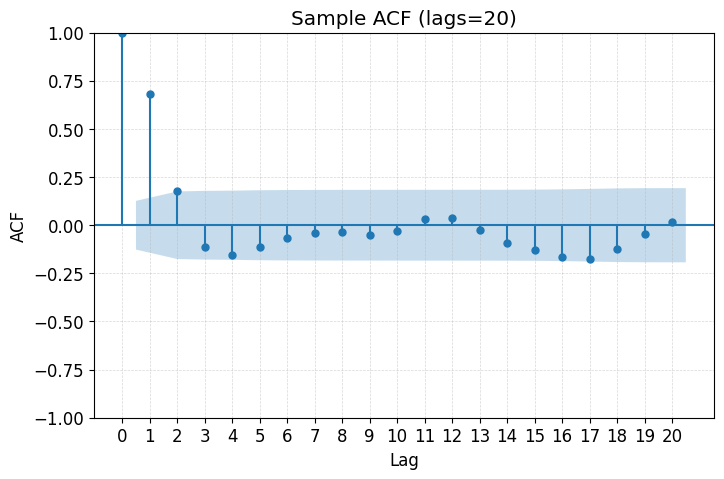

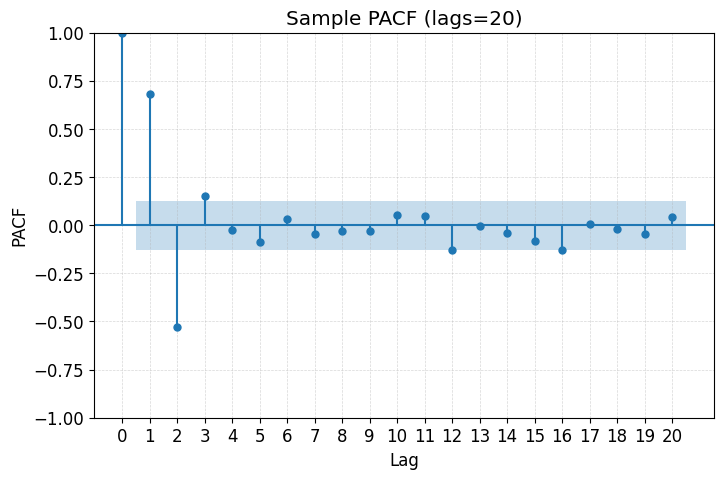

In [5]:
plot_acf_sample(X, lags=20)
plot_pacf_sample(X, lags=20)

The empirical ACF and PACF patterns are consistent with an ARMA(2,2) structure.
The PACF shows two significant partial autocorrelations followed by values within the confidence bands, which is characteristic of an AR(2) model.
The ACF decays gradually instead of cutting off abruptly, indicating that a moving–average structure is also present, supporting the inclusion of an MA(2) component.

### Model Selection Using BIC

In [6]:
df_models = arma_model_selection(X)
print(df_models)

c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


    p  q         AIC         BIC      LogLik
0   2  3  659.807223  684.171696 -322.903612
1   1  3  661.005772  681.889606 -324.502886
2   3  3  661.392702  689.237814 -322.696351
3   0  2  662.177683  676.100239 -327.088842
4   3  0  662.339602  679.742796 -326.169801
5   2  1  662.460317  679.863511 -326.230158
6   0  3  662.518762  679.921956 -326.259381
7   1  2  662.743455  680.146649 -326.371727
8   2  2  662.882667  683.766500 -325.441333
9   3  2  663.635102  687.999574 -324.817551
10  3  1  664.069393  684.953227 -326.034697
11  2  0  666.988746  680.911301 -329.494373
12  1  1  679.206096  693.128651 -335.603048
13  0  1  723.198679  733.640596 -358.599340
14  1  0  745.008437  755.450354 -369.504218


c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
print("\n=== Top models by AIC ===")
display(df_models.nsmallest(5, "AIC"))

print("\n=== Top models by BIC ===")
display(df_models.nsmallest(5, "BIC"))


=== Top models by AIC ===


,p,q,AIC,BIC,LogLik
0,2,3,659.807223,684.171696,-322.903612
1,1,3,661.005772,681.889606,-324.502886
2,3,3,661.392702,689.237814,-322.696351
3,0,2,662.177683,676.100239,-327.088842
4,3,0,662.339602,679.742796,-326.169801



=== Top models by BIC ===


,p,q,AIC,BIC,LogLik
3,0,2,662.177683,676.100239,-327.088842
4,3,0,662.339602,679.742796,-326.169801
5,2,1,662.460317,679.863511,-326.230158
6,0,3,662.518762,679.921956,-326.259381
7,1,2,662.743455,680.146649,-326.371727


We select the best ARMA model based on the Bayesian Information Criterion (AIC).

In [8]:
best_model = ARIMA(X, order=(2,0,3)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -322.904
Date:                Wed, 10 Dec 2025   AIC                            659.807
Time:                        06:19:55   BIC                            684.172
Sample:                             0   HQIC                           669.624
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0654      0.045     -1.462      0.144      -0.153       0.022
ar.L1          1.1581      0.122      9.488      0.000       0.919       1.397
ar.L2         -0.2201      0.118     -1.859      0.0

c:\Users\nicol\anaconda3\envs\AST\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


A grid search over ARMA models with 
p,q∈{0,1,2,3}
p,q∈{0,1,2,3} indicated that ARMA(2,3) yielded the lowest AIC. However, when examining the parameter estimates, the coefficients associated with the MA(1), MA(2), and MA(3) terms were found to be statistically insignificant (p-values ≫ 0.10). In contrast, both AR terms, AR(1) and AR(2), were statistically significant.

Therefore, although ARMA(2,3) provides the best AIC among the fitted candidates, the moving-average terms do not contribute meaningfully to the model. For reasons of parsimony and interpretability, the final chosen model is AR(2), which retains the significant autoregressive structure while discarding non-contributory MA components.

In [9]:
best_model = ARIMA(X, order=(2,0,0)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  240
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -329.494
Date:                Wed, 10 Dec 2025   AIC                            666.989
Time:                        06:19:55   BIC                            680.911
Sample:                             0   HQIC                           672.599
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0421      0.128     -0.330      0.741      -0.292       0.208
ar.L1          1.0491      0.052     19.991      0.000       0.946       1.152
ar.L2         -0.5349      0.050    -10.673      0.0

In [10]:
significant_params(best_model, alpha=0.05)

Significant at 5.0% level:
       coef   std_err        pvalue
1  1.049116  0.052480  6.619953e-89
2 -0.534873  0.050114  1.361264e-26
3  0.907068  0.086550  1.064622e-25

Not significant at 5.0% level:
       coef   std_err    pvalue
0 -0.042089  0.127541  0.741399


Conclusion: At the 5% significance level, all dynamic model coefficients are statistically significant, while the constant term is not.

## Prediction

In [11]:
X_train, y_test = X[:216], X[216:]
model = ARIMA(X_train, order=(2,0,0)).fit()
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -294.483
Date:                Wed, 10 Dec 2025   AIC                            596.966
Time:                        06:19:55   BIC                            610.467
Sample:                             0   HQIC                           602.421
                                - 216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0598      0.136     -0.440      0.660      -0.326       0.207
ar.L1          1.0481      0.055     19.224      0.000       0.941       1.155
ar.L2         -0.5216      0.052    -10.037      0.0

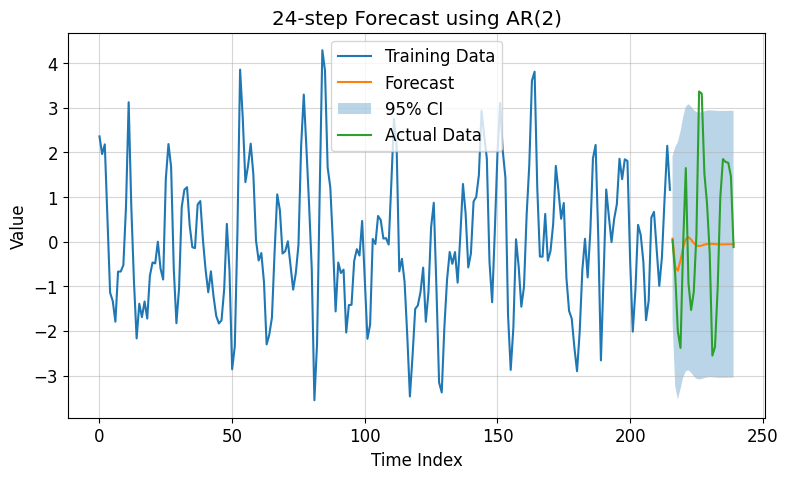

In [12]:
pred, ci = arma_forecast_plot(model, X_train, y_test, steps=24,
                              title='24-step Forecast using AR(2)')

In [13]:
ci_df = forecast_with_ci(model, steps=24)
print(ci_df)

95% Confidence Intervals:
    Forecast  Lower 95%  Upper 95%
0   0.067172  -1.781299   1.915642
1  -0.562582  -3.240261   2.115096
2  -0.652988  -3.535136   2.229161
3  -0.419253  -3.303385   2.464879
4  -0.127130  -3.045247   2.790988
5   0.057113  -2.907182   3.021409
6   0.097836  -2.883107   3.078779
7   0.044413  -2.937092   3.025918
8  -0.032818  -3.016118   2.950481
9  -0.085895  -3.072413   2.900622
10 -0.101238  -3.089151   2.886675
11 -0.089633  -3.077638   2.898371
12 -0.069467  -3.057561   2.918626
13 -0.054386  -3.042702   2.933930
14 -0.049098  -3.037528   2.939332
15 -0.051423  -3.039865   2.937019
16 -0.056618  -3.045063   2.931828
17 -0.060849  -3.049310   2.927611
18 -0.062575  -3.051044   2.925895
19 -0.062176  -3.050647   2.926295
20 -0.060858  -3.049329   2.927613
21 -0.059684  -3.048156   2.928788
22 -0.059142  -3.047615   2.929330
23 -0.059186  -3.047659   2.929287
    Forecast  Lower 95%  Upper 95%
0   0.067172  -1.781299   1.915642
1  -0.562582  -3.240261   2.1

In [14]:
rmse_train, rmse_test = calculate_rmse(model, X_train, y_test)

RMSE (Training): 0.952017401181902
RMSE (Test): 1.6629457683390314


## Residual Diagnostics

=== Residuals Statistics ===
Mean: 0.0030
Standard Deviation: 0.9520
Minimum: -2.4668, Maximum: 2.4158


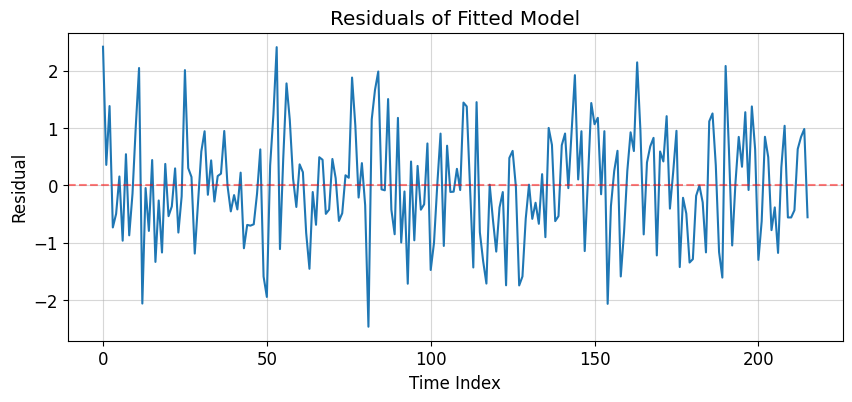

In [15]:
residuals = model.resid
residual_stats = plot_residuals(model.resid)

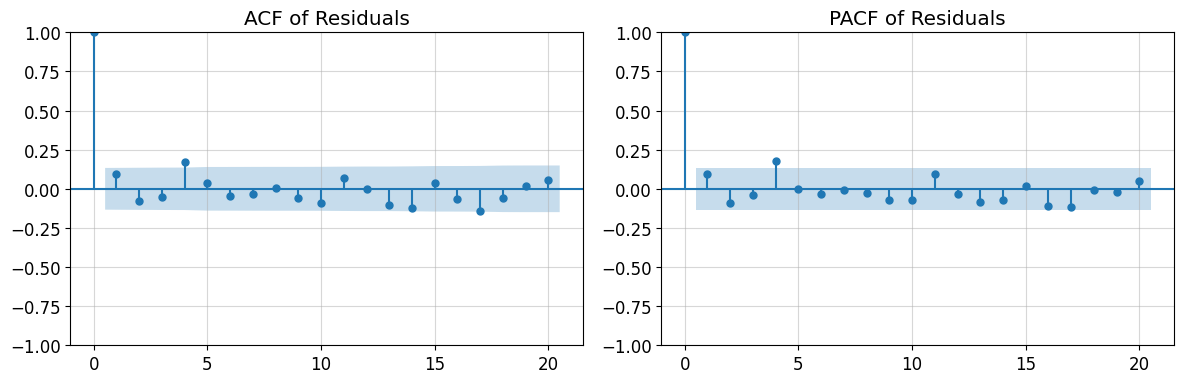

In [16]:
plot_acf_pacf_residuals(model.resid, lags=20)

The residuals of the ARIMA(2,0,0) model behave as white noise, as all autocorrelations fall within the 95% confidence bounds. This indicates that the model adequately captures the autocorrelation structure of the training data.

In [17]:
lb_test = acorr_ljungbox(residuals, lags=[10, 15, 20], return_df=True)

print("=== Ljung-Box Test for Residuals ===")
print(lb_test)


=== Ljung-Box Test for Residuals ===
      lb_stat  lb_pvalue
10  14.386462   0.156082
15  21.728830   0.115114
20  29.398648   0.080201


The Ljung-Box test results indicate that the residuals of the ARIMA(2,0,0) model are consistent with white noise. All tested lags have p-values above 0.05, confirming that the model adequately captures the autocorrelation structure of the training data.

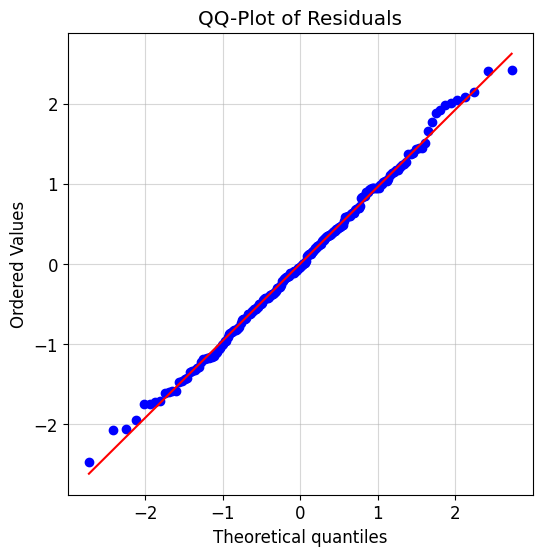

Shapiro-Wilk Test:
Statistic: 0.9958, p-value: 0.8197

Jarque-Bera Test:
Statistic: 1.0329, p-value: 0.5966


In [18]:
normality_results = residuals_normality_test(model.resid)

The residuals of the ARIMA(2,0,0) model are approximately normally distributed. Both the QQ-plot and formal tests (Shapiro-Wilk and Jarque-Bera) support this conclusion, as all points align with the reference line and the p-values are well above 0.05.